In [13]:
import scipy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import math

Getting 1000 samples of a normal distribution. Verifying they fall within that distribution

In [2]:
mean = 0 
sd = 1
X = stats.norm(mean, sd)
samples = X.rvs(100000)
a, b = np.percentile(samples, [2.5, 97.5])
sample_range = b - a
if np.isclose(np.mean(samples), mean, atol=0.01):
    print("Sample mean is about equal to distribution mean")
if np.isclose(np.std(samples), sd, atol=0.01):
    print("Sample standard deviation is about equal to distribition std")
if np.isclose(sample_range , 2*1.95, atol=0.1):
    print("Sample 95% range is close to the distribition IQR")

Sample mean is about equal to distribution mean
Sample standard deviation is about equal to distribition std
Sample 95% range is close to the distribition IQR


In [3]:
def observed_prop(x, X):
    """
    Given an observed value, return the observed sample proportion
    of that value in the data. 
    
    Params
    ------
        x (any): observation you want the frequency for
        X (List): list of samples from which to calculate proportion
    
    Returns
    -------
        proportion (float): proportion of sample where x was observed
    """
    count = sum([1 if x_i==x else 0 for x_i in X])
    return count / len(X)

def p_normal(x, mu, std): 
    """
    Return the probability of observing X assuming X ~ N(mu, std)

    Params
    ------
        mu (float): the mean parameter of the normal 
        std (float): the sd parameter of the normal 
    
    Returns
    -------
        p_x (float): probability of observing x given X ~ N(mu, std)
    """
    return (1 / (std * np.sqrt(2 * np.pi))) * np.e ** (-1 * ((x - mu)**2/(2 * std**2)))


Now let's verify that the sample proportions equal the probability distribution of the Normal

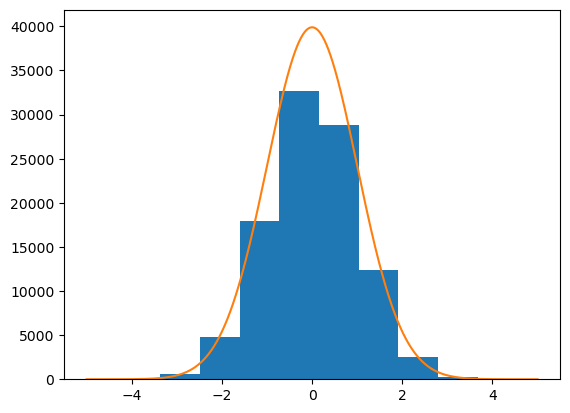

In [4]:
mean = 0 
sd = 1
X = stats.norm(mean, sd)
samples = X.rvs(100000)
observed = []
pdf = []

for x_i in np.linspace(-5, 5, 1000):
    observed = np.append(observed, observed_prop(x_i, samples))
    pdf = np.append(pdf, p_normal(x_i, mean, sd))

# plot the sample distribution
plt.hist(samples)

#plot the pdf
plt.plot(np.linspace(-5, 5, 1000), pdf * 100000)

plt.show()
    
        


Remember Bayes' rule? 

$$ p(\theta | y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$

The probability of the model being true given some data is the probability of that data arising from that model, times the prior probability of that model, divided by the probability of the data.

You can swap "model" with hypothesis. 

To conceptualize models we'll need to break Bayes' Rule down to meaningful parts: 

$$ p(\theta): Prior$$
$$ p(y | \theta): Likelihood $$
$$ p(\theta | y): Posterior $$
$$ p(y): Marginal\:Likelihood $$

The <strong>prior distribution</strong> should reflect what we know about the value of the $ \theta $ parameter before seeing the data. 

The <strong>likelihood</strong> is an expression of the plausibility of the data given the parameters. 

The <strong>posterior distribution</strong> is the result of our Bayesian analusis, and reflects all information about the problem (given our data andm odel). The posterior is a probability distribution (pdf) for the $\theta$ parameters in our model. 

<em>Note: Coneceptually we can think of the posterior as the updated prior in light of our data. In fact, the posterior from one analysis can be used as the prior for a new analysis (ex: online algorithms)</em>

The <strong>marginal likelihood</strong>, also known as <strong>evidence</strong> is the probability of observing the data averaged over all possible values the parameters can take. 

#### Single Parameter Inference

Probabilities are used to measure the uncertainty we have about parameters, and Bayes' theorem is the mechanism to correctly update those probabilities in light of new data, hopefully reducing our uncertainty. 

To explore inference, we'll do the age-old coin flipping problem. 

Problem Statement: Given an array of coin flips (0 for heads, 1 for tails), return True or False if the coin is biased. 

For us to do a Bayesian Analysis, we'll need to define our 4 parts: Prior, Likelihood, Posterior, and Marginal Likelihood. 

We'll start by defining our <em>prior</em> as the probability of getting heads, or our <strong>bias</strong>. If $\theta = 1$, then we expect all heads. 0, we expect all tails. 0.5, heads half the time, tails half the time. 

Next we'll define our <em>likelihood</em>. In this case, our likelihood would be the probability of getting our data given our bias $\theta$ and the number of trials. We can expect coin flips to be independent, identically distributed. A binomial distribution would be a good fit for this. We can write this as: 

$$ p(y|\theta, N) = \binom{N}{y}\theta^{y}(1 - \theta)^{(N-y)} $$

Let's code up a function for our likelihood.





In [5]:
def binomial_pmf(y, theta, N):
    """
    Given number of successes y, a probability of success
    theta, and number of trials N, return the probability of getting
    exactly K successes. 

    Params
    ------
        y (int): Number of successful trials 
        theta (float): Probability of success of each trial 
        N (int): Number of trials 
    
    Returns
    -------
        (float): probability of getting exactly y successes
    """
    return math.comb(N, y) * theta ** y * (1-theta)**(N-y)

Text(0, 0.5, 'p(y|θ, N)')

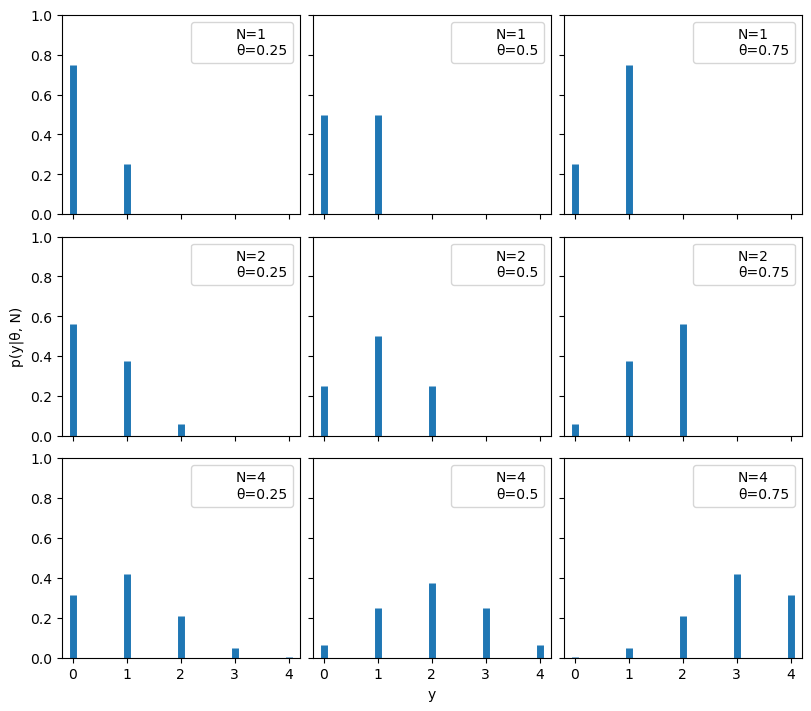

In [12]:
n_params = [1, 2, 4] # number of trials
p_params = [0.25, 0.5, 0.75] # probability of success

x = np.arange(0, max(n_params) + 1) # range of num successes
# Make a matplotlib figure. Subdivide it into subplots we'll iterate over
fig, ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True, figsize=(8,7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = [binomial_pmf(x_i, p, n) for x_i in x]

        ax[i, j].vlines(x, 0, y, colors='C0', lw=5) # draw vertical lines
        ax[i, j].set_ylim(0, 1) # probability goes from 0 to 1
        ax[i, j].plot(x, y, alpha=0, label=f"N={n}\nθ={p}")
        ax[i, j].legend()

ax[2, 1].set_xlabel('y')
ax[1, 0].set_ylabel('p(y|θ, N)')

Ok this looks like a good likelihood distribution. When our bias approaches 1, we see more successes. When our bias approaches 0, we see more failures. 

This, however, doesn't tell us the bias given data. When we have a likelihood, and we want to find the probability of the parameter, we use a prior and combine both via Bayes' rule.

#### Choosing the Prior

For this prior we'll choose the beta distribution. The beta distribution goes as follows: 

$$ p(\theta| \alpha, \beta) = \frac{\Gamma{(\alpha + \beta)}}{\Gamma{(\alpha)}\Gamma{(\beta)}}\:\theta^{\alpha - 1}\:(1-\theta)^{\beta - 1}$$

The first term of this is just a normalization constant. It exists so our function outputs probabilities in the range(0, 1) and all our probabilities sum to 1. So in reality we can rewrite this as a proportion: 

$$ p(\theta| \alpha, \beta) \propto \theta^{\alpha - 1}\:(1-\theta)^{\beta - 1}$$

We choose the gamma distribution for a couple reasons. One is that it's a very versatile function. We can produce a lot of shapes by varying $\alpha$ and $\beta$, making it possible to model normal and uniform-like distributions from the same function, just tuning the parameters. See for yourself:

In [15]:
def beta_pdf(theta, alpha, beta):
    """
    Given the beta parameters alpha and beta, return the probability density
    at theta

    Params 
    ------
        theta (float-like): observation you'd like probability density for
        alpha (float-like): alpha parameter of beta dist
        beta (float-like): beta parameter of beta dist
    
    Returns
    -------
        prob_density (float): probability density at theta of B(alpha, beta)
    """
    norm_constant = scipy.special.gamma(alpha + beta) / (scipy.special.gamma(alpha) * scipy.special.gamma(beta))
    return  norm_constant * theta ** (alpha - 1) * (1 - theta) ** (beta - 1)

/var/folders/mn/xk12q_t57y1889l8g92dyp8m0000gn/T/ipykernel_82309/2425308842.py:17: RuntimeWarning: divide by zero encountered in scalar power
  return  norm_constant * theta ** (alpha - 1) * (1 - theta) ** (beta - 1)


Text(0.07, 0.5, 'p(θ)')

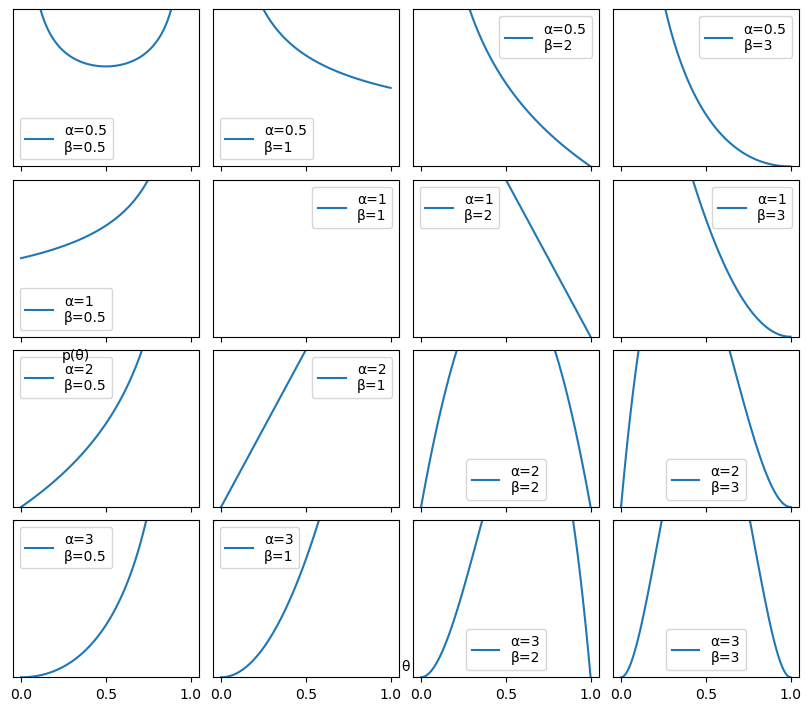

In [36]:
params = [0.5, 1, 2, 3] #example params for alpha and beta

x = np.linspace(0, 1, 100) # Our bias goes from [0, 1]. This gives us 100 example theta values to draw the pdf
# Make a matplotlib figure. Subdivide it into subplots we'll iterate over
fig, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True, figsize=(8,7), constrained_layout=True)

for i in range(len(params)):
    for j in range(len(params)):
        a = params[i]
        b = params[j]

        y = [beta_pdf(x_i, a, b) for x_i in x]

        ax[i, j].set_ylim(0, 1) # probability goes from 0 to 1
        ax[i, j].plot(x, y, label=f"α={a}\nβ={b}")
        ax[i, j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
fig.text(0.5, 0.05, 'θ', ha='center')
fig.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

The other reason we want to use the beta distribution, is because it's proportional to the binomial. Recall from above: 

$$ p(\theta| \alpha, \beta) \propto \theta^{\alpha - 1}\:(1-\theta)^{\beta - 1}$$

And finally it's because the beta distribution and the binomial distribution are <strong>conjugate pairs</strong>. The beta distribution is the <strong>conjugate prior</strong> of the binomial distribution. This means that when used as a prior for the binomial dist. as the likelihood, the posterior will have the same functional form as the prior. 

In simpler terms, everytime we use the beta distribution as the prior of the binomial distribution, we'll get a beta distribution as the posterior. 